In [1]:
# Import our dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


## Import Data

In [2]:
# Import our input dataset
charity_df = pd.read_csv('charity_data.csv')
charity_df.head(3)

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0


In [3]:
charity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EIN                     34299 non-null  int64 
 1   NAME                    34299 non-null  object
 2   APPLICATION_TYPE        34299 non-null  object
 3   AFFILIATION             34299 non-null  object
 4   CLASSIFICATION          34299 non-null  object
 5   USE_CASE                34299 non-null  object
 6   ORGANIZATION            34299 non-null  object
 7   STATUS                  34299 non-null  int64 
 8   INCOME_AMT              34299 non-null  object
 9   SPECIAL_CONSIDERATIONS  34299 non-null  object
 10  ASK_AMT                 34299 non-null  int64 
 11  IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.1+ MB


### Remove non-essential features

In [4]:
remove_columns = ['EIN', 'NAME']
name_df = charity_df[remove_columns]
name_df.head(3)

,EIN,NAME
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS


### Input DataFrame before Categorical Encoding

In [5]:
charity_df = charity_df.drop(columns=remove_columns)
charity_df.shape

(34299, 10)

### Categorical Variables Encoding

In [6]:
# Generate our categorical variable list
cat_list = list(charity_df.dtypes[charity_df.dtypes == "object"].index)
# Check the number of unique values in each column
charity_df[cat_list].nunique()

APPLICATION_TYPE          17
AFFILIATION                6
CLASSIFICATION            71
USE_CASE                   5
ORGANIZATION               4
INCOME_AMT                 9
SPECIAL_CONSIDERATIONS     2
dtype: int64

In [7]:
# return a table groupby the given column name, with count and 'IS_SUCCESSFUL' mean 
def categorical_variable_bin_table_get(col):
    t = charity_df[[col, 'IS_SUCCESSFUL']].copy().groupby(col).agg({'count', 'mean'})
    t.columns = ['cnt', 'avg']
    return t.sort_values(by=['cnt'], ascending=False)

# find the cutoff categorical variable to meet the threshold.
def categorical_variable_bin_cutoff(t_df, thres=0.95):
    total = t_df['cnt'].sum()
    thres = thres * total
    cat_count_list = list(t_df['cnt'])
    sum = 0
    for idx, cnt in enumerate(cat_count_list):
        sum = sum + cnt
        if (sum > thres):
            break
    print(f'sum = {sum}, total={total}, ratio={sum/total*100:.2f}%; items={idx + 1}, cnt={cnt}')
    return cnt

# replace the categorical variable to "Others_Lo" and "Others_Hi"
def categorical_variables_replace(t_df, cat, cnt, avg=-1):
    for var in list(t_df[t_df.cnt < cnt].index):
        if (t_df.at[var, 'avg'] < avg):
            charity_df[cat] = charity_df[cat].replace(var, "Others_Lo")
        else:
            charity_df[cat] = charity_df[cat].replace(var, "Others_Hi")

#### APPLICATION_TYPE

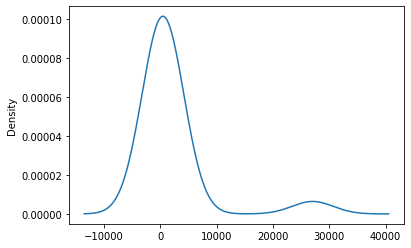

In [8]:
# Visualize the value counts
app_type_counts = charity_df.APPLICATION_TYPE.value_counts()
app_type_counts.plot.density()

In [9]:
category = 'APPLICATION_TYPE' 
t_df = categorical_variable_bin_table_get(category)
t_df

,cnt,avg
APPLICATION_TYPE,,
T3,27037,0.532160
T4,1542,0.305447
T6,1216,0.740132
T5,1173,0.767263
T19,1065,0.188732
T8,737,0.421981
T7,725,0.565517
T10,528,0.878788
T9,156,0.717949


In [10]:
# Check out the categroical variable 
cnt = categorical_variable_bin_cutoff(t_df, 0.95)

sum = 32770, total=34299, ratio=95.54%; items=6, cnt=737


In [11]:
categorical_variables_replace(t_df, category, cnt, 0.7)
# Check to make sure binning was successful
categorical_variable_bin_table_get(category)

,cnt,avg
APPLICATION_TYPE,,
T3,27037,0.532160
T4,1542,0.305447
T6,1216,0.740132
T5,1173,0.767263
T19,1065,0.188732
Others_Hi,785,0.852229
Others_Lo,744,0.565860
T8,737,0.421981


#### AFFILIATION

In [12]:
category = 'AFFILIATION'
t_df = categorical_variable_bin_table_get(category)
t_df.head(10)

,cnt,avg
AFFILIATION,,
Independent,18480,0.702435
CompanySponsored,15705,0.331869
Family/Parent,64,0.562500
National,33,0.606061
Regional,13,0.615385
Other,4,1.000000


In [13]:
# Replace in DataFrame
cnt = 64 + 1
categorical_variables_replace(t_df, category, cnt, 0.5)

# Check to make sure binning was successful
categorical_variable_bin_table_get(category)

,cnt,avg
AFFILIATION,,
Independent,18480,0.702435
CompanySponsored,15705,0.331869
Others_Hi,114,0.596491


#### CLASSIFICATION

In [14]:
category = 'CLASSIFICATION'
t_df = categorical_variable_bin_table_get(category)
t_df.head(10)

,cnt,avg
CLASSIFICATION,,
C1000,17326,0.563315
C2000,6074,0.531939
C1200,4837,0.462683
C3000,1918,0.484880
C2100,1883,0.226235
C7000,777,0.893179
C1700,287,0.602787
C4000,194,0.829897
C5000,116,0.051724


In [15]:
# Check out the categroical variable 
cnt = categorical_variable_bin_cutoff(t_df, 0.95)

sum = 32815, total=34299, ratio=95.67%; items=6, cnt=777


In [16]:
# Replace in DataFrame
categorical_variables_replace(t_df, category, cnt, 0.5)

# Check to make sure binning was successful
categorical_variable_bin_table_get(category)

,cnt,avg
CLASSIFICATION,,
C1000,17326,0.563315
C2000,6074,0.531939
C1200,4837,0.462683
C3000,1918,0.484880
C2100,1883,0.226235
Others_Hi,1256,0.754777
C7000,777,0.893179
Others_Lo,228,0.149123


### USE_CASE

In [17]:
category = 'USE_CASE'
t_df = categorical_variable_bin_table_get(category)
t_df.head(10)

,cnt,avg
USE_CASE,,
Preservation,28095,0.538067
ProductDev,5671,0.519132
CommunityServ,384,0.348958
Heathcare,146,0.431507
Other,3,1.000000


#### ORGANIZATION

In [18]:
category = 'ORGANIZATION' 
t_df = categorical_variable_bin_table_get(category)
t_df.head(10)

,cnt,avg
ORGANIZATION,,
Trust,23515,0.587200
Association,10255,0.395222
Co-operative,486,0.755144
Corporation,43,0.767442


In [19]:
# Replace in DataFrame
cnt = 486 + 1
categorical_variables_replace(t_df, category, cnt, 0.5)

# Check to make sure binning was successful
categorical_variable_bin_table_get(category)

,cnt,avg
ORGANIZATION,,
Trust,23515,0.587200
Association,10255,0.395222
Others_Hi,529,0.756144


#### SPECIAL_CONSIDERATIONS

In [20]:
category = 'SPECIAL_CONSIDERATIONS'
t_df = categorical_variable_bin_table_get(category)
t_df.head(10)

,cnt,avg
SPECIAL_CONSIDERATIONS,,
N,34272,0.53233
Y,27,0.62963


In [21]:
charity_df = charity_df.drop(columns=[category])

#### regenerate categorical variable list

In [22]:
# Generate our categorical variable list
cat_list = charity_df.dtypes[charity_df.dtypes == "object"].index.tolist()
# Check the number of unique values in each column
charity_df[cat_list].nunique()

APPLICATION_TYPE    8
AFFILIATION         3
CLASSIFICATION      8
USE_CASE            5
ORGANIZATION        3
INCOME_AMT          9
dtype: int64

#### INCOME_AMT

In [23]:
# Print out the INCOME_AMT value counts
category = 'INCOME_AMT'
t_df = categorical_variable_bin_table_get(category)
t_df.head(10)

,cnt,avg
INCOME_AMT,,
0,24388,0.515704
25000-99999,3747,0.569789
100000-499999,3374,0.578542
1M-5M,955,0.465969
1-9999,728,0.759615
10000-24999,543,0.677716
10M-50M,240,0.404167
5M-10M,185,0.470270
50M+,139,0.338129


In [24]:
# Check out the categroical variable 
cnt = categorical_variable_bin_cutoff(t_df, 0.95)

sum = 33192, total=34299, ratio=96.77%; items=5, cnt=728


In [25]:
# Replace in DataFrame
categorical_variables_replace(t_df, category, cnt, 0.5)

# Check to make sure binning was successful
categorical_variable_bin_table_get(category)

,cnt,avg
INCOME_AMT,,
0,24388,0.515704
25000-99999,3747,0.569789
100000-499999,3374,0.578542
1M-5M,955,0.465969
1-9999,728,0.759615
Others_Lo,564,0.409574
Others_Hi,543,0.677716


### Done Categorical variables processing

In [26]:
charity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   APPLICATION_TYPE  34299 non-null  object
 1   AFFILIATION       34299 non-null  object
 2   CLASSIFICATION    34299 non-null  object
 3   USE_CASE          34299 non-null  object
 4   ORGANIZATION      34299 non-null  object
 5   STATUS            34299 non-null  int64 
 6   INCOME_AMT        34299 non-null  object
 7   ASK_AMT           34299 non-null  int64 
 8   IS_SUCCESSFUL     34299 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 2.4+ MB


#### ASK_AMT           

In [27]:
charity_df['ASK_AMT'].describe()

count    3.429900e+04
mean     2.769199e+06
std      8.713045e+07
min      5.000000e+03
25%      5.000000e+03
50%      5.000000e+03
75%      7.742000e+03
max      8.597806e+09
Name: ASK_AMT, dtype: float64

In [28]:
charity_df['ASK_AMT'] = np.log(charity_df['ASK_AMT'])
charity_df['ASK_AMT'].describe()

count    34299.000000
mean         9.412030
std          1.865495
min          8.517193
25%          8.517193
50%          8.517193
75%          8.954415
max         22.874773
Name: ASK_AMT, dtype: float64

### final DataFrame

In [29]:
final_df = pd.get_dummies(charity_df, columns=cat_list, drop_first=True)
final_df.head(3)

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Others_Lo,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T8,...,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Others_Hi,ORGANIZATION_Trust,INCOME_AMT_1-9999,INCOME_AMT_100000-499999,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_Others_Hi,INCOME_AMT_Others_Lo
0,1,8.517193,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,11.595335,1,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
2,1,8.517193,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [30]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   STATUS                      34299 non-null  int64  
 1   ASK_AMT                     34299 non-null  float64
 2   IS_SUCCESSFUL               34299 non-null  int64  
 3   APPLICATION_TYPE_Others_Lo  34299 non-null  uint8  
 4   APPLICATION_TYPE_T19        34299 non-null  uint8  
 5   APPLICATION_TYPE_T3         34299 non-null  uint8  
 6   APPLICATION_TYPE_T4         34299 non-null  uint8  
 7   APPLICATION_TYPE_T5         34299 non-null  uint8  
 8   APPLICATION_TYPE_T6         34299 non-null  uint8  
 9   APPLICATION_TYPE_T8         34299 non-null  uint8  
 10  AFFILIATION_Independent     34299 non-null  uint8  
 11  AFFILIATION_Others_Hi       34299 non-null  uint8  
 12  CLASSIFICATION_C1200        34299 non-null  uint8  
 13  CLASSIFICATION_C2000        342

## Split Data: train / test

In [31]:
# Split our preprocessed data into our features and target arrays
y = final_df["IS_SUCCESSFUL"].values
X = final_df.drop(columns = ["IS_SUCCESSFUL"]).values

In [32]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

### Scale

In [33]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### TensorFlow NN

In [34]:
def nn_builder(number_input_features, hidden_nodes):
    nn = Sequential()

    # First hidden layer
    nn.add(Dense(units=hidden_nodes[0], input_dim=number_input_features, activation="relu"))

    # hidden layers, exclude the first hidden layer
    for layer, h_node in enumerate(hidden_nodes):
        # done First hidden layer already.
        if layer == 0:
            continue
        nn.add(Dense(units=h_node, activation="relu"))

    # Output layer
    nn.add(Dense(units=1, activation="sigmoid"))

    # Compile the Sequential model together and customize metrics
    nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Check the structure of the model
    nn.summary()
    return nn

### three layers

In [35]:
# build deep neural network
nn = nn_builder(len(X_train[0]), [30, 20, 10])

# Train the model 
fit_model = nn.fit(X_train_scaled, y_train, epochs=30) 

# Evaluate the model using the test data 
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
_________________________________________________________________
Train on 25724 samples
Epoch 1/30
25724/25724 [==============================] - 1s 46us/sample - loss: 0.5857 - accuracy: 0.7078
Epoch 2/30
25724/25724 [==============================] - 1s 28us/sample - loss: 0.5539 - accuracy: 0.7292
Epoch 3/30
2572

In [36]:
# Export our model to HDF5 file
nn.save("three_layers.h5")

### two layers

In [37]:
# build deep neural network
nn = nn_builder(len(X_train[0]), [25, 10])

# Train the model 
fit_model = nn.fit(X_train_scaled, y_train, epochs=30) 

# Evaluate the model using the test data 
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,046
Trainable params: 1,046
Non-trainable params: 0
_________________________________________________________________
Train on 25724 samples
Epoch 1/30
25724/25724 [==============================] - 1s 43us/sample - loss: 0.5905 - accuracy: 0.7056
Epoch 2/30
25724/25724 [==============================] - 1s 31us/sample - loss: 0.5546 - accuracy: 0.7290
Epoch 3/30
25724/25724 [==============================] - 1s 28us/sample - loss: 0.5513 - accuracy: 0.7310
Epoch 4/30
25724/25724 [==============

In [38]:
# Export our model to HDF5 file
nn.save("two_layers.h5")

### one layer

In [39]:
# build deep neural network
nn = nn_builder(len(X_train[0]), [20])

# Train the model 
fit_model = nn.fit(X_train_scaled, y_train, epochs=30) 

# Evaluate the model using the test data 
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
Train on 25724 samples
Epoch 1/30
25724/25724 [==============================] - 1s 39us/sample - loss: 0.6050 - accuracy: 0.6969
Epoch 2/30
25724/25724 [==============================] - 1s 28us/sample - loss: 0.5637 - accuracy: 0.7246
Epoch 3/30
25724/25724 [==============================] - 1s 28us/sample - loss: 0.5555 - accuracy: 0.7286
Epoch 4/30
25724/25724 [==============================] - 1s 29us/sample - loss: 0.5525 - accuracy: 0.7284
Epoch 5/30
25724/25724 [==============================] - 1s 27us/s

In [40]:
# Export our model to HDF5 file
nn.save("one_layers.h5")

### better one

In [42]:
# Import the model to a new object
nn_imported = tf.keras.models.load_model('two_layers.h5')

# Evaluate the model using the test data 
model_loss, model_accuracy = nn_imported.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8575/8575 - 0s - loss: 0.5482 - accuracy: 0.7268
Loss: 0.5481892812286799, Accuracy: 0.7267638444900513
